In [5]:
import pandas as pd
import pyarrow.parquet as pq
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sbs

# Introduction

We aim to extract meaningful data from the GDELT 2.0 dataset. 

We want to analyse the media coverage of violent events in some specific countries (Afghanistan, Syria, Iraq, Pakistan and Mexico) over the years 2000 to 2016.

We used :

* *ActionGeo_CountryName*, the 2-character FIPS10-4 country code for the location of the events to get the countries.
* [*EventRootCode*](http://data.gdeltproject.org/documentation/CAMEO.Manual.1.1b3.pdf) 18, 19 and 20 that correspond to the most violent events in the documentation.
* *MonthYear* to have the date (in month and year) of each event
* *Events* that we got from our SQL query as being the number of events per month
* *Articles* from our SQL query as well, being the number of Articles per month

We chose to extract data from the [**UCDP**](http://ucdp.uu.se/) dataset, we kept only our featured countries and the best estimation given for the number of deaths per year.

## Processing of the UCDP dataset

In [6]:
# Getting deaths datasets (UCDP)

deaths = pd.read_csv('ged171.csv')
deaths = deaths[(deaths['year'] >= 2000) & (deaths['year'] <= 2016)]
deaths = deaths[['year', 'country', 'best']]
deaths.columns = ['Date', 'Country', 'Deaths']

Create one dataframe per country:

In [7]:
def deaths_country(_df, country_name):
    x = _df[_df['Country'] == country_name].drop('Country', axis=1).groupby('Date').sum().reset_index()
    if(country_name == 'Mexico'):
        # We need to artificially add some rows for mexico due to missing (no deaths) data these years
        x = x.append(pd.DataFrame([[2003, 0], [2000, 0], [2001, 0]], columns=['Date', 'Deaths'])).sort_values('Date')
    x['Deaths'] = x['Deaths']
    return x.set_index('Date')

In [8]:
deaths_irq = deaths_country(deaths, 'Iraq')
deaths_afg = deaths_country(deaths, 'Afghanistan')
deaths_mex = deaths_country(deaths, 'Mexico')
deaths_pak = deaths_country(deaths, 'Pakistan')

deaths_irq.head()

,Deaths
Date,
2000,185
2001,27
2002,111
2003,7999
2004,4365


## Processing of our aggregation of the GDELT dataset

We first tried to get the data from the cluseter but the dataset present on it was a subset of GDELT. Therefore most of the features were missing. To get the location of an event we used at first "Source" and "Target" field that matched the country we were intrested in. But those entries were not consistent.
The full dataset was supposed to have an ActionGeo_Country code which represent the county were the event took place. We were also supposed to have access to features like "MonthYear", "EventRootCode",...

For all those reasons we decided to stop using the cluster and make our query on the full GDELT dataset using the [Google Big Query](https://bigquery.cloud.google.com/table/gdelt-bq:gdeltv2.events)

The sql queries can be found on the repository

In [9]:
# Getting the aggregate dataset from our GDELT query (2000-2016)

df = pd.read_csv('big_query_2000_2016.csv')
df.columns = ['Country', 'Date', 'EventCode', 'Events', 'Articles']

The data that we get out of our query is the number of Event and the number of Articles aggregated per country, MonthYear and EventCode.
Aggregating the data this way enables us to work on a consise dataset(compared to the original enormous GDELT). However we still keep the different event code and month data separated for further analysis.

In [10]:
df.head()

,Country,Date,EventCode,Events,Articles
0,SY,201609,19,26118,558078
1,SY,201608,19,23797,513882
2,SY,201602,19,27567,483618
3,SY,201510,19,27216,469990
4,SY,201612,19,22474,468685


In [11]:
def df_country(_df, country):
    return _df[_df.Country == country].drop('Country', axis=1).set_index(['Date'])

DataFrame with merged event code:

In [12]:
df_grouped = df.groupby(['Date', 'Country']).sum().drop(['EventCode'], axis=1).sort_index(level=[0,1])

df_merged = df_grouped.reset_index()

irq = df_country(df_merged, 'IRQ')
mex = df_country(df_merged, 'MEX')
pak = df_country(df_merged, 'PAK')
afg = df_country(df_merged, 'AFG')
syr = df_country(df_merged, 'SYR')

df_merged.head()

,Date,Country,Events,Articles
0,200001,AF,198,919
1,200001,IZ,272,1407
2,200001,MX,99,402
3,200001,PK,896,5068
4,200001,SY,185,734


## Separation by country and aggregation per year

In [13]:
# Here we process the dataset to only reason by year and normalize the Articles and Events by year. We then
# get the Ratio Articles/Events

df_year = df_merged.copy()

df_year['Date'] = df_year['Date'].apply(lambda d: int(d/100))

df_year = df_year.groupby(['Date', 'Country']).mean()
df_year = (df_year / df_year.std()).reset_index()

df_year['Ratio'] = df_year['Articles'] / df_year['Events'].astype('float')

df_year.drop(['Articles', 'Events'], axis=1, inplace=True)

irq_year1 = df_country(df_year, 'IZ')
mex_year1 = df_country(df_year, 'MX')
pak_year1 = df_country(df_year, 'PK')
afg_year1 = df_country(df_year, 'AF')
syr_year1 = df_country(df_year, 'SY')

df_year.head()

,Date,Country,Ratio
0,2000,AF,0.291235
1,2000,IZ,0.292026
2,2000,MX,0.303106
3,2000,PK,0.333469
4,2000,SY,0.222977


## Some plots and describes

## Normalization

We chose to normalize the ratio during the aggregation by year and normalize the deaths with a mean/std normalization. It seems to give reasonablre results for now but we might do a more refined normalization in the future.

In [16]:
def normalize(_df):
    x = _df.copy()
    d = x['Deaths']
    x['Deaths'] = abs(d - d.mean()) / d.std()
    return x

irq_year = deaths_irq.join(irq_year1)
mex_year = deaths_mex.join(mex_year1)
pak_year = deaths_pak.join(pak_year1)
afg_year = deaths_afg.join(afg_year1)

irq_year_normalized = normalize(irq_year)
mex_year_normalized = normalize(mex_year)
pak_year_normalized = normalize(pak_year)
afg_year_normalized = normalize(afg_year)

## Some exploration of the data through description and plots

In [17]:
irq_year.describe()

,Deaths,Ratio
count,17.000000,17.000000
mean,4459.294118,0.626435
std,4390.300499,0.354003
min,27.000000,0.262596
25%,1407.000000,0.331927
50%,3521.000000,0.408428
75%,4609.000000,0.921170
max,15010.000000,1.286663


In [18]:
mex_year.describe()

,Deaths,Ratio
count,17.000000,17.000000
mean,1115.764706,0.530763
std,1041.491450,0.283851
min,0.000000,0.205151
25%,187.000000,0.277822
50%,776.000000,0.389559
75%,1699.000000,0.811363
max,3313.000000,1.012106


In [19]:
pak_year.describe()

,Deaths,Ratio
count,17.000000,17.000000
mean,2290.882353,0.475536
std,2437.833974,0.200685
min,1.000000,0.202586
25%,241.000000,0.299917
50%,1366.000000,0.369654
75%,3540.000000,0.645365
max,7460.000000,0.800782


In [20]:
afg_year.describe()

,Deaths,Ratio
count,17.000000,17.000000
mean,7038.176471,0.586093
std,5235.884622,0.328073
min,817.000000,0.232169
25%,4982.000000,0.310971
50%,6499.000000,0.392297
75%,7822.000000,0.857860
max,18707.000000,1.188007


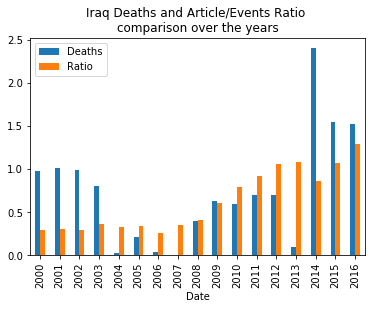

In [21]:
irq_year_normalized.plot(kind='bar', title='Iraq Deaths and Article/Events Ratio \ncomparison over the years');

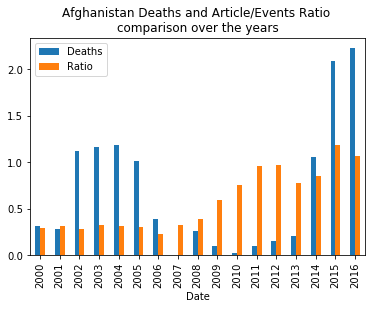

In [22]:
afg_year_normalized.plot(kind='bar', title='Afghanistan Deaths and Article/Events Ratio \ncomparison over the years');

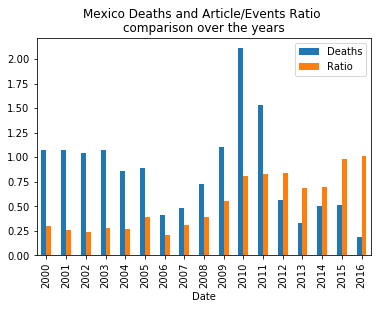

In [23]:
mex_year_normalized.plot(kind='bar', title='Mexico Deaths and Article/Events Ratio \ncomparison over the years');

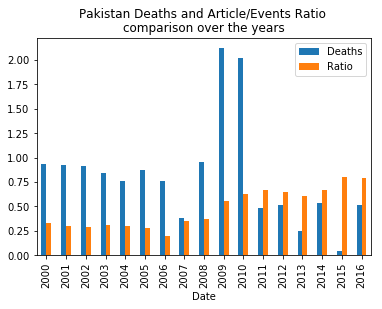

In [24]:
pak_year_normalized.plot(kind='bar', title='Pakistan Deaths and Article/Events Ratio \ncomparison over the years');

There seem to indeed be some inconsistencies in the ratio between the number of deaths and the amount of media coverage per year as we planned, though not always exactly as we would have thought.

In [25]:
data  = [irq_year_normalized,afg_year_normalized,mex_year_normalized,pak_year_normalized]
data = pd.concat(data, axis=1)

data.columns = [x + '_' + y for y in ['Deaths', 'Ratio'] for x in ['Iraq', 'Afghanistan', 'Mexico', 'Pakistan']]

data

,Iraq_Deaths,Afghanistan_Deaths,Mexico_Deaths,Pakistan_Deaths,Iraq_Ratio,Afghanistan_Ratio,Mexico_Ratio,Pakistan_Ratio
Date,,,,,,,,
2000,0.973577,0.292026,0.314021,0.291235,1.071314,0.303106,0.939310,0.333469
2001,1.009565,0.308065,0.283653,0.313035,1.071314,0.258430,0.929055,0.296111
2002,0.990432,0.299064,1.123244,0.288083,1.046350,0.235939,0.917570,0.286741
2003,0.806256,0.367202,1.163925,0.326056,1.071314,0.277822,0.840862,0.309685
2004,0.021478,0.331927,1.188181,0.310971,0.860079,0.266485,0.763334,0.299917
2005,0.213720,0.345710,1.017436,0.308419,0.891764,0.386613,0.876960,0.276848
2006,0.034099,0.262596,0.392709,0.232169,0.412644,0.205151,0.764565,0.202586
2007,0.006766,0.354628,0.003472,0.324147,0.485616,0.303617,0.379387,0.346389
2008,0.393434,0.408428,0.263218,0.392297,0.723228,0.389559,0.955405,0.369654


## Analysis by Event Code

In [26]:
df.head()

,Country,Date,EventCode,Events,Articles
0,SY,201609,19,26118,558078
1,SY,201608,19,23797,513882
2,SY,201602,19,27567,483618
3,SY,201510,19,27216,469990
4,SY,201612,19,22474,468685


In [27]:
def df_env_year(_df, country_code):
    x = _df[_df['Country'] == country_code].drop('Country', axis=1)
    x['Date'] = x['Date'].apply(lambda d: int(d / 100))
    return x.groupby(['Date', 'EventCode']).mean()

df_env = df.copy()

df_env['Ratio'] = df_env['Articles'] / df_env['Events'].astype('float')

df_env.drop(['Articles', 'Events'], axis=1, inplace=True)

irq_ev = df_env_year(df_env, 'IZ')
mex_ev = df_env_year(df_env, 'MX')
afg_ev = df_env_year(df_env, 'AF')
pak_ev = df_env_year(df_env, 'PK')
syr_ev = df_env_year(df_env, 'SY')

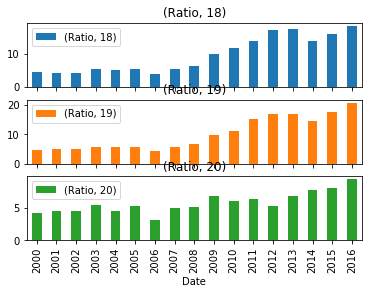

In [28]:
irq_ev.groupby(['Date', 'EventCode']).mean().unstack(level=1).plot(kind='bar', subplots=True);

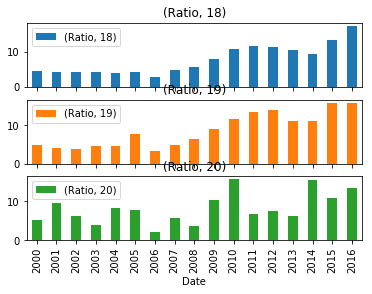

In [29]:
mex_ev.groupby(['Date', 'EventCode']).mean().unstack(level=1).plot(kind='bar', subplots=True);

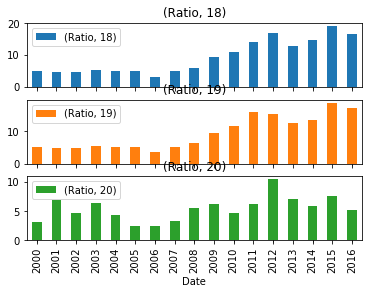

In [30]:
afg_ev.groupby(['Date', 'EventCode']).mean().unstack(level=1).plot(kind='bar', subplots=True);

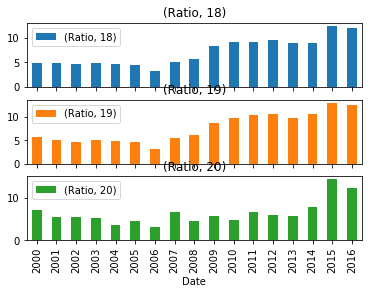

In [31]:
pak_ev.groupby(['Date', 'EventCode']).mean().unstack(level=1).plot(kind='bar', subplots=True);

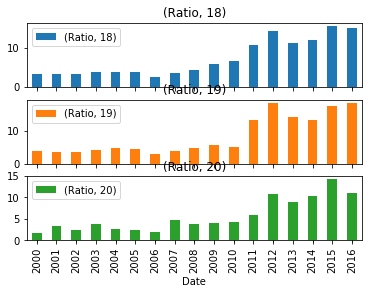

In [32]:
syr_ev.groupby(['Date', 'EventCode']).mean().unstack(level=1).plot(kind='bar', subplots=True);

As we can see, the type of the events (18, 19 or 20) seems not to influence too much the final ratio between the number of events (i.e. each event has a relatively similar curve shape). This means that our choice of events is sound and can be used without worrying too much about event importance.

In [40]:
te = pd.read_csv("top_event_2000_2016.csv")
ta = pd.read_csv("top_acticles_2000_2016.csv")
te.set_index("ActionGeo_CountryCode").head(10)

,Sum_Events
ActionGeo_CountryCode,
US,9495320
IS,1388619
PK,1388042
IZ,1244830
AF,1176532
SY,1153458
UK,1054506
IN,1012818
RS,777605


In [41]:
ta.set_index("ActionGeo_CountryCode").head(10)

,Sum_Articles
ActionGeo_CountryCode,
US,126189062
SY,18233243
IS,16038607
IZ,15565613
AF,14920597
PK,14025192
UK,9708506
IN,8898081
AS,8213297


# Discussion

First, we know from our different queries that the number of article has greatly increase during the period of time we considered, namely 2000 to 2016. The number of sources that were scrap for each event has also changed over time. Therefore we will have to be careful to not interpret the number articles evolution in itself without care as a media coverage mesure.
The Syrian death reports seems to be temporary not available on the UDCP platform. 
Another important thing is that the articles sources seems to be mainly centered on american news platforms. This can be seen in the last two plots. The total number of event and articles for the US is huge. Therefore events in the US are more documented than other countries. That is why we think that US news are more investigated.
